Chargement des données d'entraînement et de test...
Données chargées - X_train: (63232, 99), y_train: (63232,)
Données chargées - X_test: (15808, 99), y_test: (15808,)

Aperçu des données d'entraînement:
                    id  minimum_nights  \
0             29796655              30   
1              3245443               2   
2             36974694              30   
3  1083149056826568850               1   
4  1191236837847411641               3   

                                                name   latitude  longitude  \
0  Studio au calme Butte aux cailles (bail mobilité)  48.827350   2.342370   
1                     Cosy double room near the park  48.877690   2.375660   
2  Cosy Studio 30min Champs Elysées,  Batignolles 17  48.888250   2.322730   
3       Superb and New Studio in the Center of Paris  48.869015   2.351562   
4        Loft de charme proche des Grands Boulevards  48.872840   2.350152   

   number_of_reviews  accommodates  bedrooms  beds  review_scores_rating  

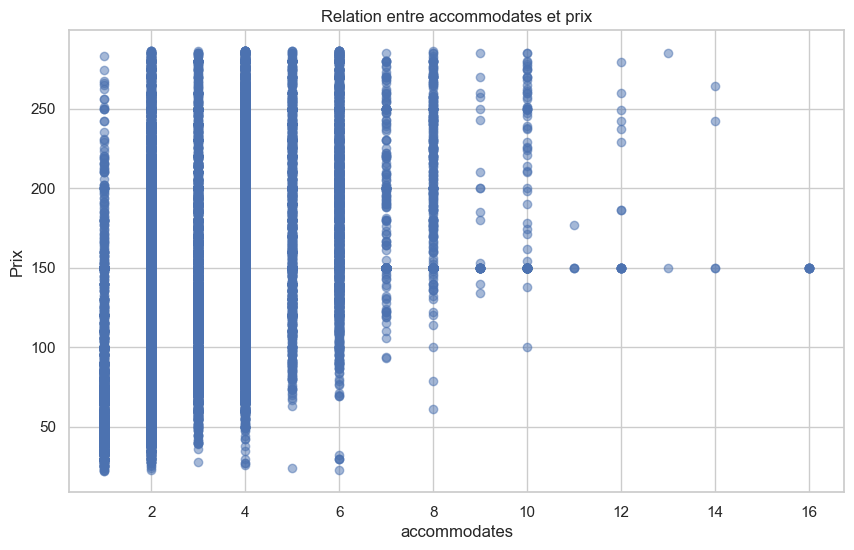


Entraînement de la régression linéaire simple avec la feature 'accommodates'
MSE (entraînement): 1864.61
MSE (test): 1919.74
RMSE (entraînement): 43.18
RMSE (test): 43.81
R² (entraînement): 0.12
R² (test): 0.12
Modèle sauvegardé dans 'models/linear_regression_simple_accommodates.pkl'


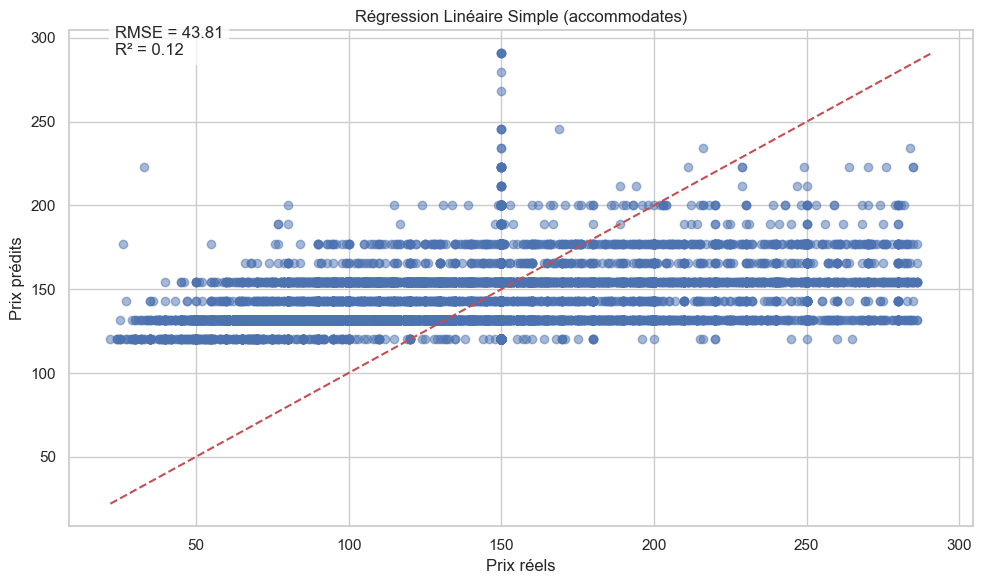


RÉGRESSION LINÉAIRE MULTIPLE

Entraînement de la régression linéaire multiple
Utilisation de 10 colonnes numériques sur 99 colonnes totales
MSE (entraînement): 2113.29
MSE (test): 2166.98
RMSE (entraînement): 45.97
RMSE (test): 46.55
R² (entraînement): 0.00
R² (test): 0.00

Coefficients du modèle:
                Feature   Coefficient
1        minimum_nights  0.000000e+00
2              latitude  0.000000e+00
3             longitude  0.000000e+00
4     number_of_reviews  0.000000e+00
5          accommodates  0.000000e+00
6              bedrooms  0.000000e+00
7                  beds  0.000000e+00
8  review_scores_rating  0.000000e+00
9     host_is_superhost  0.000000e+00
0                    id -4.256457e-18
Modèle sauvegardé dans 'models/multiple_regression.pkl'


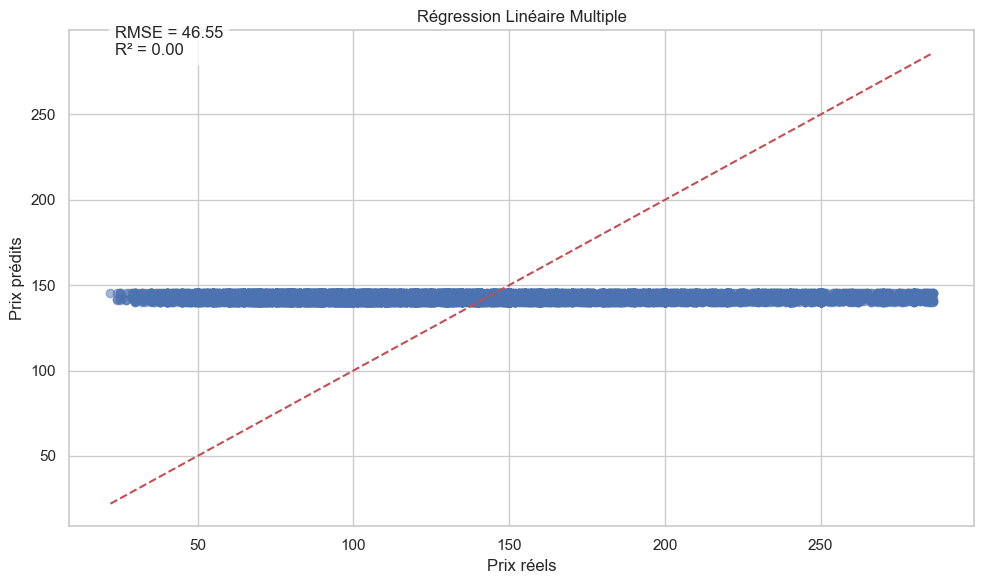

      Métrique  Régression Simple (accommodates)  Régression Multiple
0   MSE (test)                       1919.737270          2166.976641
1  RMSE (test)                         43.814807            46.550796
2    R² (test)                          0.116311             0.002502

Entraînement d'un modèle Random Forest...

Random Forest - RMSE: 35.70, R²: 0.41

Comparaison des modèles:
      Métrique  Régression Simple (accommodates)  Régression Multiple  \
0   MSE (test)                       1919.737270          2166.976641   
1  RMSE (test)                         43.814807            46.550796   
2    R² (test)                          0.116311             0.002502   

   Random Forest  
0    1274.839129  
1      35.704889  
2       0.413169  

Modèle Random Forest sauvegardé dans '../models/random_forest.pkl'


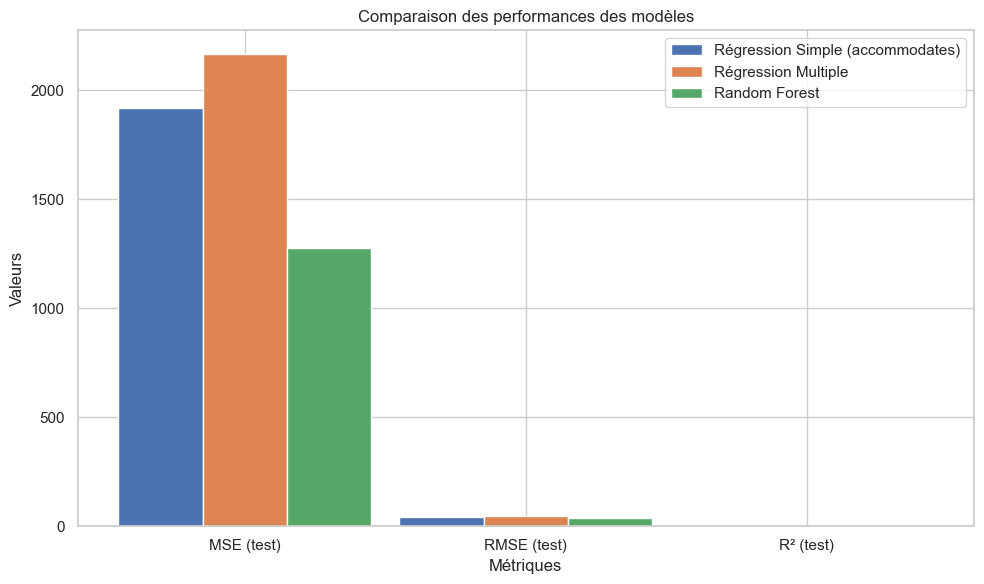

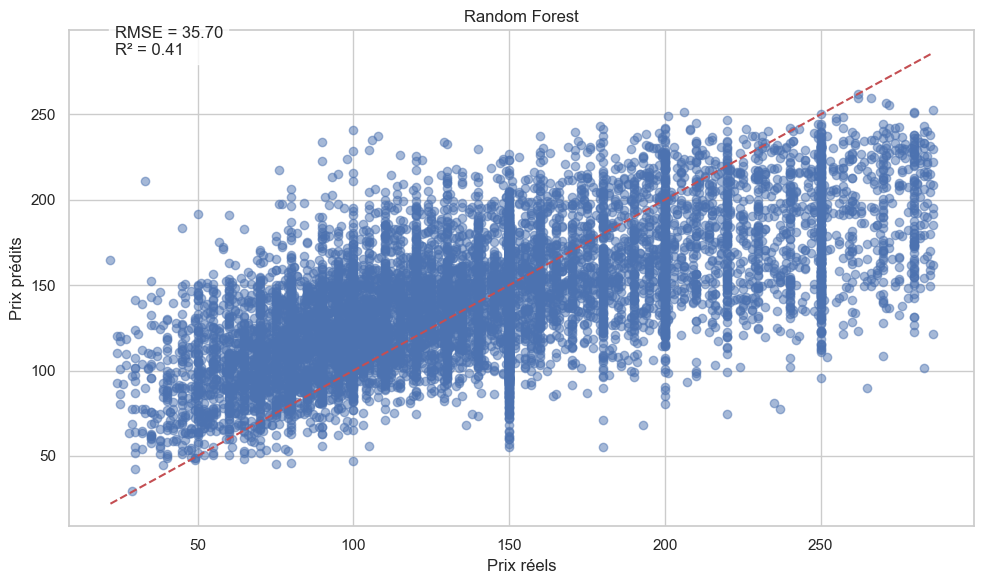

In [7]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Configuration des graphiques
sns.set(style='whitegrid')

# Ajouter le dossier parent au chemin pour importer les modules
sys.path.append('..')

# Importer les fonctions du module model_training
from src.model_training import (
    load_data,
    train_simple_linear_regression,
    train_multiple_linear_regression,
    visualize_predictions
)

# 1. Chargement des données
print("Chargement des données d'entraînement et de test...")
try:
    X_train, y_train, X_test, y_test = load_data(
        "../data/splits/train.csv", 
        "../data/splits/test.csv"
    )
except Exception as e:
    print(f"Erreur lors du chargement des données: {e}")
    sys.exit(1)

# Vérifier la cohérence des données
if X_train.empty or y_train.empty:
    print("Les données d'entraînement sont vides. Vérifiez les fichiers.")
    sys.exit(1)

# Aperçu des données
print("\nAperçu des données d'entraînement:")
print(X_train.head())

print("\nStatistiques descriptives des prix (cible):")
print(y_train.describe())

# 2. Sélection d'une feature pour la régression simple
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns

if len(numeric_features) > 0:
    correlations = [
        (feature, y_train.corr(X_train[feature]))
        for feature in numeric_features
    ]
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("\nCorrelations des features numériques avec le prix:")
    for feature, corr in correlations:
        print(f"{feature}: {corr:.4f}")

    best_feature = correlations[0][0]
    print(f"\nFeature avec la plus forte corrélation: {best_feature} ({correlations[0][1]:.4f})")
else:
    best_feature = X_train.columns[0]
    print(f"\nAucune feature numérique trouvée, utilisation de: {best_feature}")

# 3. Régression linéaire simple
print("\n========================")
print("RÉGRESSION LINÉAIRE SIMPLE")
print("========================")

plt.figure(figsize=(10, 6))
plt.scatter(X_train[best_feature], y_train, alpha=0.5)
plt.xlabel(best_feature)
plt.ylabel('Prix')
plt.title(f'Relation entre {best_feature} et prix')
plt.grid(True)
plt.show()

model_simple, metrics_simple, y_pred_simple = train_simple_linear_regression(
    X_train, X_test, y_train, y_test, best_feature
)
visualize_predictions(y_test, y_pred_simple, f"Régression Linéaire Simple ({best_feature})")
plt.show()

# 4. Régression linéaire multiple
print("\n========================")
print("RÉGRESSION LINÉAIRE MULTIPLE")
print("========================")

model_multiple, metrics_multiple, y_pred_multiple = train_multiple_linear_regression(
    X_train, X_test, y_train, y_test
)
visualize_predictions(y_test, y_pred_multiple, "Régression Linéaire Multiple")
plt.show()

# 5. Comparaison des modèles
comparison = pd.DataFrame({
    'Métrique': ['MSE (test)', 'RMSE (test)', 'R² (test)'],
    f'Régression Simple ({best_feature})': [
        metrics_simple.get('test_mse', np.nan),
        metrics_simple.get('test_rmse', np.nan),
        metrics_simple.get('test_r2', np.nan)
    ],
    'Régression Multiple': [
        metrics_multiple.get('test_mse', np.nan),
        metrics_multiple.get('test_rmse', np.nan),
        metrics_multiple.get('test_r2', np.nan)
    ]
})

print(comparison)

# 6. Random Forest
print("\nEntraînement d'un modèle Random Forest...")

# Drop non-numeric columns from X_train and X_test
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_numeric, y_train)
y_pred_rf = model_rf.predict(X_test_numeric)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest - RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

comparison['Random Forest'] = [
    mean_squared_error(y_test, y_pred_rf),
    rf_rmse,
    rf_r2
]

print("\nComparaison des modèles:")
print(comparison)

# Sauvegarder le modèle Random Forest
os.makedirs("../models", exist_ok=True)
joblib.dump(model_rf, "../models/random_forest.pkl")
print("\nModèle Random Forest sauvegardé dans '../models/random_forest.pkl'")

# Visualisation de la comparaison des performances
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
index = np.arange(len(comparison))

for i, model in enumerate(comparison.columns[1:]):
    ax.bar(index + i * bar_width, comparison[model], bar_width, label=model)

ax.set_xlabel('Métriques')
ax.set_ylabel('Valeurs')
ax.set_title('Comparaison des performances des modèles')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(comparison['Métrique'])
ax.legend()

plt.tight_layout()
plt.show()

# Visualisation des prédictions du Random Forest
visualize_predictions(y_test, y_pred_rf, "Random Forest")
plt.show()